# Data Wrangling Act WeRateDogs

### by Travis Gillespie

## Table of Contents
- [Introduction](#intro)
- [Gather Data](#gather)
- [Assess Data](#assess)
   - [Quality](#quality)
   - [Tidiness](#tidiness)
- [Clean Data](#clean)
- [Analyze, and Visualize](#analyzing)
   - [Insight one & visualization](#one)
   - [Insight two](#two)
   - [Insight three & visualization](#three)
   - [Insight four & visualization](#four)
- [Store](#storing)   
- [Resources](#resources)

<a id='intro'></a>
## Introduction

The purpose of this project is to wrangle data from Twitter's tweet archive, under WeRateDogs. I'm looking forward to this project because I get to use some of the skills I've learned over the certification path and through various books I've been working through the past few months. [<sup>1 - 4</sup>](#resources)

I was not able to find a general template within the project details, so I looked on github and found a common template most projects follow. [<sup>5</sup>](#resources) The table of contents above provides a quick overview of that structure.

<a id='gather'></a>
## Gathering data

This is the first step in data wrangling. In this section I will and import all three data sets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import tweepy
import json
import time
import sys
import re
from datetime import datetime, timedelta

#### Import Downloaded Data: Twitter Archive

In [2]:
# set df_twitter to twitter-archive-enhanced data
df_original_twitter = pd.read_csv('./assets/twitter-archive-enhanced.csv')

#### Download Data Programatically: Tweet Image Prediction

In [3]:
# set site to url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# check that response.status_code returns 200
print(response)

<Response [200]>


In [4]:
# Use file to refer to the file object
with open('./assets/image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
# set tsv to df_imagePredictions
df_original_imagePredictions = pd.read_csv('./assets/image-predictions.tsv', sep='\t')

#### Query JSON Data: Twitter API

In [5]:
# created twitter account to authenticate twitter api at https://apps.twitter.com/app
# consumer_key = 'Consumer Key (API key)'
# consumer_secret = 'Consumer Secret (API Secret)'
# access_token = 'Access Token'
# access_token_secret = 'Access Token Secret'

# removed strings to submit project
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# build API instance
api = tweepy.API(auth_handler = auth)

In [6]:
# converted type as string to use in twitter query below
# set time delays
tweetIDsList = df_original_twitter['tweet_id'].astype(str)
timeDelay = round(1 / (len(tweetIDsList) / (15*60)),2) # time to wait and avoid RateLimitError
timeDelay # time delay is set to run about 2 querys per second, this should give a total time of 15minutes when querying for data below


0.38

In [7]:
# query Twitter using values in tweetIDsList
tweet = {}
errorList = []
total = len(tweetIDsList) - 1  # total number to reach minus 1 b/c i starts at 0
bar_length = 30  # should be less than 100
i = 0

for tweetID in tweetIDsList:
    
    percent = 100.0*i/total
    errorType = ""

    try:
        status = api.get_status(tweetID, 
                                retry_count = 1, # default number of retries to attempt when error occurs
                                retry_delay = 2, # number of seconds to wait between retries
                                timeout = 60, # maximum amount of time to wait for a response from Twitter
                                wait_on_rate_limit = True, # wait for rate limits to restore
                                wait_on_rate_notify = True) # print notification when Tweepy is waiting for rate limits to restore

        tweet[tweetID] = status._json

    except tweepy.RateLimitError as error:
        # print("\n\nID: " + tweetID + "-> RateLimitError: " + str(error) + "\n\n")
        errorList.append("ID: " + tweetID + "-> Error: " + str(error))        
        time.sleep(15 * 60) # sleep for 15 minutes rather than default 10 minutes
        
    except tweepy.TweepError as error:
        # print("\n\nID: " + tweetID + "-> TweepError: " + str(error) + "\n\n")
        errorList.append("ID: " + tweetID + "-> Error: " + str(error))
        
    except Exception as error:
        # print("\n\nID: " + tweetID + "-> Error: " + str(error) + "\n\n")        
        errorList.append("ID: " + tweetID + "-> Error: " + str(error))
        

    # progress bar go get some coffee while you wait
    sys.stdout.write('\r')
    sys.stdout.write("Completed: {}/{} ≈ "
                     .format(i,total))
    sys.stdout.write("{:>3}% [{:{}}]"
                     .format(round(float(percent),1),
                             '='*int(percent/(100.0/bar_length)), bar_length))
    sys.stdout.flush()
    time.sleep(timeDelay) # time delay is set to prevent rate limit errors
    # time.sleep(3) is equal to 3 seconds
    # time.sleep(.3) is equal to 300 milliseconds

    i = i + 1

Completed: 2355/2355 ≈ 100.0% [==============================]

Time delay is set to allow *n* amount of queries per second [<sup>6</sup>](#resources) . Due to Twitter's Rate Limits and the number of *tweetID* to query with the time delay is set to approximately 300 milliseconds ( *i.e. time.sleep(0.3)* ); allowing about two queries per second in this case. It should take roughly 15 minutes to perform all queries, which should help prevent any rate.

In [8]:
with open('./assets/tweet_json.txt', 'w') as output:
    json.dump(tweet, 
              output,
              sort_keys = True,
              indent = 4,
              ensure_ascii = False
             )

In [9]:
# read json file back in
df_original_tweets = pd.read_json('./assets/tweet_json.txt', orient = 'index')

In [10]:
# make copies of original dataframes
df_twitter = df_original_twitter.copy()
df_imagePredictions = df_original_imagePredictions.copy()
df_tweets = df_original_tweets.copy()

<a id='assess'></a>
## Assessing data

This is the second step in the data wrangling process. In this section I will look at the three data sets. First, I want to start by using *head()* to get an idea of what the data looks like within each table. Then, I will use *info()* to look at the size & shape of each table, and determine if any values are missing.

In [11]:
# df_twitter dataset
# display first 2 rows
df_twitter.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [12]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
sum(df_twitter['tweet_id'].duplicated())

0

In [14]:
# df_imagePredictions dataset
# display first 2 rows
df_imagePredictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [15]:
df_imagePredictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
sum(df_imagePredictions['tweet_id'].duplicated())

0

In [17]:
# df_tweets dataset
# display first 2 rows
df_tweets.head(2)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
1991-02-08 13:48:08.022790149,NaN,NaN,2015-11-15 22:32:08,"{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/BL...,2549,0,NaN,666020888022790144,666020888022790144,...,NaN,NaN,NaN,508,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 16:08:05.002620928,NaN,NaN,2015-11-15 23:05:30,"{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,128,0,NaN,666029285002620928,666029285002620928,...,NaN,NaN,NaN,47,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,0,"{'contributors_enabled': False, 'created_at': ..."


In [18]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2341 entries, 1991-02-08 13:48:08.022790149 to 1998-04-12 22:37:23.555336193
Data columns (total 30 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2341 non-null datetime64[ns]
entities                         2341 non-null object
extended_entities                1822 non-null object
favorite_count                   2341 non-null int64
favorited                        2341 non-null int64
geo                              0 non-null float64
id                               2341 non-null int64
id_str                           2341 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null float64
is_quote_status                  23

<a id='quality'></a>
### Quality

1. [jump to section:](#qualityNull) df_twitter and df_tweets data sets are both missing several values.

* [jump to section:](#qualityRenameColumns) Attribute fields labels are misleading or at least lacking. For example, dataframe df_twitter, column labeled _name_; is this the account owner, pet owner, or anmial's name, is this a first name or a full name?

* [jump to section:](#qualityAnimalNames) Within df_twitter, column labeled _name_, animal names are misleading or indicate non-animal names.

* [jump to section:](#qualityError) Querying Twitter database for tweetID in tweetIDsList returns the following error codes.

    * Error: [{'code': 144, 'message': 'No status found with that ID.'}]
    
    * Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}]
    
    * Error: [{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
    
    * Error: [{'message': 'Rate limit exceeded', 'code': 88}]

* [jump to section:](#qualitySeparateDateTime) Separate _timestamp_ column out into two columns; date and time.

* [jump to section:](#qualityDogType) Combine columns where possible. Similar columns are not distinct, and have similar values in separate columns. Regarding the df_imagePredictions dataframe; what's the difference between columns *p1_dog*, *p2_dog*, *p3_dog* and why are the values in separate columns?

* [jump to section:](#qualityRemoveNumerator) Remove numberator values that are too large.

* [jump to section:](#qualityIncorrectAnimals) Ensure all animals are of type dog. df_imagePredictions contains images of animals other than dogs (e.g. row 6 contains a [turtle](https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg)).

* [jump to section:](#qualityNumerator) Convert decimal values to floats.

* [jump to section:](#qualityText) Text column contains decimals (e.g. 9.75).

* I am only making a note here. Fixes are handled in different locations. df_twitter only has 2536 rows while df_imagePredictions has 2075. Clean the datasets so each column has an equal amount of entries.

* I am only making a note here. Fixes are handled in different locations. Data entries do not follow a standard convention. Dataframe df_twitter, column labeled _name_ has many rows that look like they are first names. Row number 1 is *Tilly*, row 5 is *None*, 22 is *such*, and 2327 is *a*.

<a id='tidiness'></a>
### Tidiness

1. I am only making a note here. I will not make any changes regarding this note. There are three dataframes  df_twitter, df_imagePredictions, and df_tweets. These dataframes provide information regarding tweets, but they are not organized. It would be beneficial to create an entity relationship diagram (ERD) which would help separate the information and clean these dataframes.

* [jump to section:](#tidyJoin) Another option is to join tables, rather than separating infortamion out further. This would allow me to consolidate relevant information into one table and eliminate unwanted columns. Still an ERD would be benefitial to map the datasets.

* [jump to section:](#tidyDogType) Regarding the df_twitter dataframe. My best guess is the columns _doggo_, _floofer_, _pupper_, and _puppo_ columns represent the dog's developmental stage. The dataset would be cleaner if these values were placed in one column.

* [jump to section:](#tidyReadability) Edit df_twitter column _source_ so labels are readable.

* [jump to section:](#tidyNull) Remove columns that contain only null values.

* [jump to section:](#dateTime) Convert datetime types from _object_ to _datetime_.

<a id='clean'></a>
## Cleaning Data

This is the third step in data wrangling. This is where I will fix the quality and tidiness issues previously stated.

<a id='qualityError'></a>
#### Define

*- Querying Twitter database for tweetID in tweetIDsList returns error codes.*

I could only handle this with Try and Except in the data gathering section. But I am placing all error codes handled in a log file.

#### Code

In [19]:
   
# write errorList out to log
with open('./assets/error_log.txt', 'w') as filehandle:
    for listitem in errorList:
        filehandle.write('%s\n' % listitem)

#### Test

In [20]:
df_log = pd.read_csv('./assets/error_log.txt', delimiter = "\t", header=None)
df_log.head(3)

,0
0,"ID: 888202515573088257-> Error: [{'code': 144,..."
1,"ID: 873697596434513921-> Error: [{'code': 144,..."
2,"ID: 872668790621863937-> Error: [{'code': 144,..."


<a id='tidyJoin'></a>
#### Define

*- Another option is to join tables, rather than separating infortamion out further.*

In this section I'll join [<sup>7</sup>](#resources) the tables.

In [21]:
list(df_twitter)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [22]:
list(df_tweets)

['contributors',
 'coordinates',
 'created_at',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

#### Code

In [23]:
# Join left all three dataframes df_twitter, df_imagePredictions, and df_tweets.
df_cleanData = pd.merge(df_twitter, df_imagePredictions, on = 'tweet_id', how = 'left')

# Merge two dataframes with different column names using left_on and right_on
df_cleanData = pd.merge(df_cleanData, df_tweets, how = 'left', left_on = 'tweet_id', right_on = 'id')

df_cleanData.to_csv('./assets/df_clean.csv', encoding = 'utf-8')

#### Test

In [24]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 58 columns):
tweet_id                         2356 non-null int64
in_reply_to_status_id_x          78 non-null float64
in_reply_to_user_id_x            78 non-null float64
timestamp                        2356 non-null object
source_x                         2356 non-null object
text_x                           2356 non-null object
retweeted_status_id              181 non-null float64
retweeted_status_user_id         181 non-null float64
retweeted_status_timestamp       181 non-null object
expanded_urls                    2297 non-null object
rating_numerator                 2356 non-null int64
rating_denominator               2356 non-null int64
name                             2356 non-null object
doggo                            2356 non-null object
floofer                          2356 non-null object
pupper                           2356 non-null object
puppo                            23

<a id='qualityNull'></a>
#### Define

*- df_twitter and df_tweets data sets are both missing several values.*

Remove retweets that provide null data. 

#### Code

In [25]:
# Remove retweets and keep row when isnull returns True.
df_cleanData = df_cleanData[pd.isnull(df_cleanData['retweeted_status_id'])]

#### Test

In [26]:
# shape of the remaining 
df_cleanData.shape[0]

2175

<a id=''></a>
#### Define

Remove unwanted columns and columns that contain only null values.

#### Code

In [27]:
# remove id and created_at b/c they are identical to tweet_id and timestamp
df_cleanData = df_cleanData.drop(['in_reply_to_status_id_x',
                                  'in_reply_to_user_id_x',
                                  
                                  'retweeted_status_id',
                                  'retweeted_status_user_id',                                  
                                  'retweeted_status_timestamp',

                                  'contributors',
                                  'coordinates',
                                  'created_at',
                                  'extended_entities',
                                  'geo',
                                  'id',
                                  'in_reply_to_screen_name',
                                  'in_reply_to_status_id_y',
                                  'in_reply_to_status_id_str',
                                  'in_reply_to_user_id_y',
                                  'in_reply_to_user_id_str',
                                  'quoted_status',
                                  'quoted_status_id',
                                  'quoted_status_id_str',
                                  'place',
                                  'retweeted',
                                  'source_y',
                                  'text_y'], 
                                 axis=1)

#### Test

In [28]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 35 columns):
tweet_id                         2175 non-null int64
timestamp                        2175 non-null object
source_x                         2175 non-null object
text_x                           2175 non-null object
expanded_urls                    2117 non-null object
rating_numerator                 2175 non-null int64
rating_denominator               2175 non-null int64
name                             2175 non-null object
doggo                            2175 non-null object
floofer                          2175 non-null object
pupper                           2175 non-null object
puppo                            2175 non-null object
jpg_url                          1994 non-null object
img_num                          1994 non-null float64
p1                               1994 non-null object
p1_conf                          1994 non-null float64
p1_dog                        

<a id='qualityRenameColumns'></a>
#### Define

*- Attribute fields labels are misleading or at least lacking.*

In this section, I rename columns to provide clarity.

#### Code

In [29]:
df_cleanData.rename(columns={'source_x':'source',
                             'text_x': 'text',
                             'name': 'pets_name'
                  },
          inplace=True
         )

#### Test

In [30]:
for i in df_cleanData.columns:
    print(i)

tweet_id
timestamp
source
text
expanded_urls
rating_numerator
rating_denominator
pets_name
doggo
floofer
pupper
puppo
jpg_url
img_num
p1
p1_conf
p1_dog
p2
p2_conf
p2_dog
p3
p3_conf
p3_dog
entities
favorite_count
favorited
id_str
is_quote_status
lang
possibly_sensitive
possibly_sensitive_appealable
retweet_count
retweeted_status
truncated
user


<a id='dateTime'></a>
#### Define

*- Convert datetime types from _object_ to _datetime_.*

I this sections I will convert column _timestamp_ to datatime objects.

#### Code

In [31]:
df_cleanData[['timestamp']] = df_cleanData[['timestamp']].apply(pd.to_datetime)

#### Test

In [32]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 35 columns):
tweet_id                         2175 non-null int64
timestamp                        2175 non-null datetime64[ns]
source                           2175 non-null object
text                             2175 non-null object
expanded_urls                    2117 non-null object
rating_numerator                 2175 non-null int64
rating_denominator               2175 non-null int64
pets_name                        2175 non-null object
doggo                            2175 non-null object
floofer                          2175 non-null object
pupper                           2175 non-null object
puppo                            2175 non-null object
jpg_url                          1994 non-null object
img_num                          1994 non-null float64
p1                               1994 non-null object
p1_conf                          1994 non-null float64
p1_dog                

<a id='qualitySeparateDateTime'></a>
#### Define

*- Separate timestamp column out into two columns; date and time.*

Create separate column _timestamp_ out into two separate columns _date_ and _time_, and format them accordingly. Convert the new columns to datetime objects, then drop the column _timestamp_.

#### Code

In [33]:
# df_cleanData['date'] = df_cleanData['timestamp'].apply(lambda time: time.strftime('%m-%d-%Y'))
df_cleanData['date'] = df_cleanData['timestamp'].apply(lambda time: time.strftime('%Y-%m-%d'))
df_cleanData['time'] = df_cleanData['timestamp'].apply(lambda time: time.strftime('%H:%M'))

# convert new columns to datetime objects
df_cleanData[['date']] = df_cleanData[['date']].apply(pd.to_datetime)
df_cleanData[['time']] = df_cleanData[['time']].apply(pd.to_datetime)
df_cleanData.head(1)

# Drop timestamp column
df_cleanData = df_cleanData.drop(['timestamp'], axis = 1)


#### Test

In [34]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 36 columns):
tweet_id                         2175 non-null int64
source                           2175 non-null object
text                             2175 non-null object
expanded_urls                    2117 non-null object
rating_numerator                 2175 non-null int64
rating_denominator               2175 non-null int64
pets_name                        2175 non-null object
doggo                            2175 non-null object
floofer                          2175 non-null object
pupper                           2175 non-null object
puppo                            2175 non-null object
jpg_url                          1994 non-null object
img_num                          1994 non-null float64
p1                               1994 non-null object
p1_conf                          1994 non-null float64
p1_dog                           1994 non-null object
p2                            

<a id=''></a>
#### Define

Check for duplicate tweet_id's, if so delete them.

#### Code

No code needed. The test below shows there are zero duplicates in *tweet_id*.

#### Test

In [35]:
sum(df_cleanData['tweet_id'].duplicated())

0

<a id=''></a>
#### Define

Check for tweets with missing images and drop them.

#### Code

In [36]:
missingImagesPrevious = sum(pd.isnull(df_cleanData['jpg_url']))
df_cleanData = df_cleanData.dropna(subset = ['jpg_url'])
missingImagesCurrent = sum(pd.isnull(df_cleanData['jpg_url']))

#### Test

In [37]:
print("There were %d rows missing an image." % (missingImagesPrevious))
print("There are %d rows missing an image." % (missingImagesCurrent))

There were 181 rows missing an image.
There are 0 rows missing an image.


<a id='tidyDogType'></a>
#### Define

*- Regarding the df_twitter dataframe. My best guess is the columns _doggo_, _floofer_, _pupper_, and _puppo_ columns represent the dog's developmental stage. The dataset would be cleaner if these values were placed in one column.*

Merge dog developmental stages *pupper, puppo, doggo, floofer* into one column. Any misnamed stages will need to be renamed.

#### Code

In [38]:
def replaceNames(columnName, currentValue, newValue):
    df_cleanData[columnName].replace(currentValue, newValue, inplace=True)

In [39]:
stageList = ['pupper',
             'puppo',
             'doggo',
             'floofer']

for stage in stageList:
    replaceNames(stage, 'None', '')

In [40]:
# Replacing n/a with empty strings
df_cleanData.update(df_cleanData[['pupper',
                                  'puppo',
                                  'doggo',
                                  'floofer']
                                ].fillna(''))

# Merge dog phases into one new column using sum()
df_cleanData['developmentalStage'] = df_cleanData[['doggo',
                                                   'floofer',
                                                   'pupper',
                                                   'puppo']
                                                    ].sum(axis=1)

#### Test

In [41]:
# Unique names of the developmental stages after rename
n = 0
for i in df_cleanData['developmentalStage'].unique():
    print("{}: {}".format(n, i))
    n = n + 1


0: 
1: doggo
2: puppo
3: pupper
4: floofer
5: doggopuppo
6: doggofloofer
7: doggopupper


<a id=''></a>
#### Define

There is an empty string in the list above (direclty before doggo). Also, duplicate values appear when rows have multiple entries (*e.g. doggopuppo, doggofloofer, doggopupper*). These need to be fixed. Empty strings will be coded with *no-entry*, and multiple entries will be named *multi-entry*. Then drop the columns *pupper, puppo, doggo, floofer*.

#### Code

In [42]:
# Fix the misnamed developmental stages by renaming cells that have multiple entries for developmental stage, name it multi-entry
listMultipleDogType = ['doggopuppo', 'doggofloofer', 'doggopupper']
for multiple in listMultipleDogType:
    replaceNames('developmentalStage', multiple, 'multi-entry')

# Replace empty strings with None, did this now to eliminate duplicate work if None used earlier
replaceNames('developmentalStage', '', 'no-entry')

In [43]:
# Drop various dog stages
df_cleanData = df_cleanData.drop(['pupper',
                             'puppo',
                             'doggo',
                             'floofer'],
                            axis = 1)

#### Test

In [44]:
n = 0
for i in df_cleanData['developmentalStage'].unique():
    print("{}: {}".format(n, i))
    n = n + 1

0: no-entry
1: doggo
2: puppo
3: pupper
4: floofer
5: multi-entry


In [45]:
for i in df_cleanData.columns:
    print(i)

tweet_id
source
text
expanded_urls
rating_numerator
rating_denominator
pets_name
jpg_url
img_num
p1
p1_conf
p1_dog
p2
p2_conf
p2_dog
p3
p3_conf
p3_dog
entities
favorite_count
favorited
id_str
is_quote_status
lang
possibly_sensitive
possibly_sensitive_appealable
retweet_count
retweeted_status
truncated
user
date
time
developmentalStage


<a id='qualityDogType'></a>
<a id='qualityIncorrectAnimals'></a>
#### Define

*- Combine columns where possible.*

*- Ensure all animals are of type dog.*

Create a function *dog_type()*. It will be used to place dog types *max* & *confs* values into their respective column. This function will also drop animals that are not of type dog.

#### Code

In [46]:
dogTypeMax = []
dogConfsMax = []
def dog_type(animal):
    dogs = []
    dogConfs = []
            
    if animal["p1_dog"]:
        dogs.append(animal["p1"])
        dogConfs.append(animal["p1_conf"])
    if animal["p2_dog"]:
        dogs.append(animal["p1"])        
        dogConfs.append(animal["p2_conf"])
    if animal["p3_dog"]:
        dogs.append(animal["p1"])        
        dogConfs.append(animal["p3_conf"])
    if not animal["p1_dog"] and not animal["p2_dog"] and not animal["p3_dog"]:
        dogs.append(False)
        dogConfs.append(np.nan)

    max_index = np.argmax(dogConfs)
    max_value = np.max(dogConfs)    

    dogTypeMax.append(dogs[max_index])
    dogConfsMax.append(max_value)

df_cleanData.apply(dog_type, axis = 1)
df_cleanData['dogTypeMax'] = dogTypeMax
df_cleanData['dogConfsMax'] = dogConfsMax

#### Test

In [47]:
df_cleanData['dogTypeMax'].sort_index().value_counts().head()

False                 308
golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
Name: dogTypeMax, dtype: int64

In [48]:
df_cleanData['dogConfsMax'].head()

0         NaN
1    0.323581
2    0.716012
3    0.168086
4    0.555712
Name: dogConfsMax, dtype: float64

<a id='qualityAnimalNames'></a>
#### Define

*- Animal names are misleading or indicate non-animal names.*

Fix peculiar dog names. Find the names and rename them.

#### Code

In [49]:
df_listOfNames = pd.DataFrame()
chars_1 = []
chars_2 = []
chars_3 = []
chars_4 = []
chars_5 = []
chars_6orMore = []

# function counts the places name's into lists based on character lengths
def nameCharsCount(itemNum):
    listShortNames = []
    
    for i in df_cleanData['pets_name']:
        if len(i) == itemNum:
            if itemNum == 1 and i not in chars_1:
                chars_1.append(i)
            elif itemNum == 2 and i not in chars_2:
                chars_2.append(i)
            elif itemNum == 3 and i not in chars_3:
                chars_3.append(i)
            elif itemNum == 4 and i not in chars_4:
                chars_4.append(i)
            elif itemNum == 5 and i not in chars_5:
                chars_5.append(i)
            elif itemNum >= 6 and i not in chars_6orMore:
                chars_6orMore.append(i)

# function appends empty strings to each list until each list equals the longest list's length
def appendToList(currentList, largestListLen):
    if len(currentList) < largestListLen:
        diff = largestListLen - len(currentList)
        for i in range(diff):
            currentList.append('')
    currentList.sort(reverse=False, key=lambda x: (x is '', x))
    
# call nameCharsCount 10 times
for i in range(10):
    nameCharsCount(i)

# determine which list is the longest
largestListLen = max(len(chars_1), len(chars_2), len(chars_3), len(chars_4), len(chars_5), len(chars_6orMore))

# calling the appendToList function to make each list the same length
appendToList(chars_1, largestListLen)
appendToList(chars_2, largestListLen)
appendToList(chars_3, largestListLen)
appendToList(chars_4, largestListLen)
appendToList(chars_5, largestListLen)
appendToList(chars_6orMore, largestListLen)

# place sorted lists into dataframe
df_listOfNames['chars_1'] = chars_1
df_listOfNames['chars_2'] = chars_2
df_listOfNames['chars_3'] = chars_3
df_listOfNames['chars_4'] = chars_4
df_listOfNames['chars_5'] = chars_5
df_listOfNames['chars_6orMore'] = chars_6orMore

In [50]:
df_listOfNames.head(10)

,chars_1,chars_2,chars_3,chars_4,chars_5,chars_6orMore
0,O,Al,Ace,Abby,Adele,Albert
1,a,Bo,Aja,Acro,Aiden,Aldrick
2,,Ed,Alf,Alfy,Akumi,Alejandro
3,,JD,Amy,Andy,Albus,Alexander
4,,Jo,Ash,Anna,Alfie,Ambrose
5,,Mo,Ava,Aqua,Alice,Amélie
6,,an,Ben,Arlo,Amber,Anakin
7,,by,Blu,Arya,Andru,Anthony
8,,my,Bob,Axel,Angel,Antony
9,,,Cal,BeBe,Arlen,Apollo


I'm learning to use lambda function. In this case I used it to sort each lists before adding them to the dataframe [<sup>8</sup>](#resources) . One item I'm having trouble with is using _lambda_ to do two things. I want to place empty strings at the end of each list, and sort the list with lowercase strings before uppercase strings. The lowercase values tend to not follow a naming convention that is suitable for the _name_ column. I can sort with the _str.lower()_ function by itself or use _lambda_ to place empty strings at the end of each list, but have not figured out how to do both.

In [51]:
# Replace the list of peculiar names from the dataframe

namesList = ['a',
             'actually',
             'all',
             'an',
             'by',
             'getting',
             'infuriating',
             'just',
             'life',
             'light',
             'mad',
             'my',
             'None',
             'not',
             'O',
             'old',
             'one',
             'quite',
             'such',
             'the',
             'this',
             'very']
    
for name in namesList:
    replaceNames('pets_name', name, '')


#### Test

In [52]:
df_cleanData.pets_name.head(15)

0      Phineas
1        Tilly
2       Archie
3        Darla
4     Franklin
5             
6          Jax
7             
8         Zoey
9       Cassie
10        Koda
11       Bruno
12            
13         Ted
14      Stuart
Name: pets_name, dtype: object

In [53]:
noNames = sum(df_cleanData['pets_name'] == '')
print("There are %d rows without a name." % (noNames))

There are 640 rows without a name.


<a id='tidyReadability'></a>
#### Define

*- Edit column _source_ so labels are readable.*

Tidy text within the *source* column. Make it reader friendly.

#### Code

In [54]:
uniqueSourceList = df_cleanData['source'].unique()

for s in (uniqueSourceList):
    i1 = s.find(">") + 1
    i2 = s.find("</a>")
    sNew = s[i1:i2]

    replaceNames('source',s,sNew)

#### Test

In [55]:
uniqueSource = df_cleanData['source'].unique()

for i in uniqueSource:
    print(i)

Twitter for iPhone
Twitter Web Client
TweetDeck


<a id='qualityNumerator'></a>
#### Define

*- Convert decimal values to floats.*

Convert the data type for *rating_numerator* and *rating_denominator*.

#### Code

In [56]:
# convert type
df_cleanData['rating_numerator'] = df_cleanData['rating_numerator'].astype(float)
df_cleanData['rating_denominator'] = df_cleanData['rating_denominator'].astype(float)

In [57]:
df_cleanData['rating_numerator']

0       13.0
1       13.0
2       12.0
3       13.0
4       12.0
5       13.0
6       13.0
7       13.0
8       13.0
9       14.0
10      13.0
11      13.0
12      13.0
13      12.0
14      13.0
15      13.0
16      12.0
17      13.0
18      13.0
20      12.0
21      13.0
22      14.0
23      13.0
24      13.0
25      12.0
26      13.0
27      13.0
28      13.0
29      12.0
31      13.0
        ... 
2326     2.0
2327     7.0
2328     9.0
2329    11.0
2330     6.0
2331     8.0
2332    10.0
2333     9.0
2334     3.0
2335     1.0
2336    11.0
2337    10.0
2338     1.0
2339    11.0
2340     8.0
2341     9.0
2342     6.0
2343    10.0
2344     9.0
2345    10.0
2346     8.0
2347     9.0
2348    10.0
2349     2.0
2350    10.0
2351     5.0
2352     6.0
2353     9.0
2354     7.0
2355     8.0
Name: rating_numerator, Length: 1994, dtype: float64

In [58]:
with open('./assets/numerator.txt', 'w') as filehandle:
    for numerator in df_cleanData['rating_numerator']:
        filehandle.write('%s\n' % numerator)

#### Test

In [59]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 35 columns):
tweet_id                         1994 non-null int64
source                           1994 non-null object
text                             1994 non-null object
expanded_urls                    1994 non-null object
rating_numerator                 1994 non-null float64
rating_denominator               1994 non-null float64
pets_name                        1994 non-null object
jpg_url                          1994 non-null object
img_num                          1994 non-null float64
p1                               1994 non-null object
p1_conf                          1994 non-null float64
p1_dog                           1994 non-null object
p2                               1994 non-null object
p2_conf                          1994 non-null float64
p2_dog                           1994 non-null object
p3                               1994 non-null object
p3_conf                  

In [60]:
print(df_cleanData['rating_denominator'].unique())

[  10.   70.    7.  150.   11.  170.   20.   50.   90.   80.   40.  130.
  110.  120.    2.]


<a id='qualityText'></a>
#### Define

*- Text column contains decimals (e.g. 9.75).*

Find decimal values in text, pull decimal values from text and re-run ratings.

#### Code

In [61]:
textRatingList = []

df_cleanData['text'].apply(lambda x: textRatingList.append(re.findall(r'((?:\d+\.)?\d+)\/(\d+)', x, flags=0)))

ratingList = []
dogList = []

# print(len(df_cleanData['text'])) -> 1994
# print(len(textRatingList)) -> 1994
# print(len(df_cleanData)) -> 1994
# print(index) -> 1993

for item in textRatingList:
#     print(index)
#     index = index + 1         
    
    # tweet doesn't have a rating, but has a count of 1
    if len(item) == 0:
        ratingList.append('')
        dogList.append(1)

    # tweets have one rating and count of 1
    elif len(item) == 1 and item[0][-1] == '10':
        value = round(float(item[0][0]), 2)
        ratingList.append(value)
        dogList.append(1)

    # exactly one rating
    elif len(item) == 1:
        value = (float(item[0][-1]) / 10)
        division = round(float(item[0][0]) / value, 2)
        ratingList.append(division)
        dogList.append(value)
        
    # tweets with multiple ratings
    elif len(item) > 1:
        total = 0
        tempRatingList = []
        for i in range(len(item)):
            if item[i][-1] == '10':
                tempRatingList.append(item[i])
        for rate in tempRatingList:
            total = total + float(rate[0])

        newRating = round(total / len(item), 2)
        ratingList.append(newRating) 
        dogList.append(len(item))
        
    # if error occurs
    else:
        errorString = ('Did not parse')
        ratingList.append(errorString) 
        dogList.append(errorString)   
                
# print(len(ratingList))
# print(len(dogList))

df_cleanData['new_dog_rating'] = ratingList
df_cleanData['dog_counts'] = dogList
df_cleanData['new_dog_rating'].value_counts()


12.00      453
10.00      410
11.00      399
13.00      261
9.00       151
8.00        94
7.00        53
14.00       35
6.00        32
5.00        31
3.00        19
4.00        14
2.00         9
1.00         4
8.50         4
9.50         3
7.50         3
4.50         2
0.00         2
6.50         2
5.50         2
10.50        2
11.50        1
9.75         1
1776.00      1
9.67         1
34.29        1
13.50        1
11.26        1
11.27        1
420.00       1
Name: new_dog_rating, dtype: int64

#### Test

In [62]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 37 columns):
tweet_id                         1994 non-null int64
source                           1994 non-null object
text                             1994 non-null object
expanded_urls                    1994 non-null object
rating_numerator                 1994 non-null float64
rating_denominator               1994 non-null float64
pets_name                        1994 non-null object
jpg_url                          1994 non-null object
img_num                          1994 non-null float64
p1                               1994 non-null object
p1_conf                          1994 non-null float64
p1_dog                           1994 non-null object
p2                               1994 non-null object
p2_conf                          1994 non-null float64
p2_dog                           1994 non-null object
p3                               1994 non-null object
p3_conf                  

<a id='qualityRemoveNumerator'></a>
#### Define

*- Remove numberator values that are too large.*

Remove ratings in numerator that are greater than the highest sanctioned value.

#### Code

In [63]:
# commented out this line of code b/c it drops entries down from 1975 to 305
df_cleanData.dropna(subset = ["developmentalStage"], inplace = True)
df_cleanData = df_cleanData[~(df_cleanData["rating_numerator"] > 15)]

#### Test

In [64]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2355
Data columns (total 37 columns):
tweet_id                         1975 non-null int64
source                           1975 non-null object
text                             1975 non-null object
expanded_urls                    1975 non-null object
rating_numerator                 1975 non-null float64
rating_denominator               1975 non-null float64
pets_name                        1975 non-null object
jpg_url                          1975 non-null object
img_num                          1975 non-null float64
p1                               1975 non-null object
p1_conf                          1975 non-null float64
p1_dog                           1975 non-null object
p2                               1975 non-null object
p2_conf                          1975 non-null float64
p2_dog                           1975 non-null object
p3                               1975 non-null object
p3_conf                  

<a id='tidyNull'></a>
#### Define

_- Remove columns that contain only null values._

Drop remaining unwanted columns and last set of null values. I played around with both dropping unwanted columns from a dataframe, and creating new dataframes with desired columns. In this project, I found two advantages to dropping columns and working with the dataframe, rather than creating a new dataframe to work with that contained only desired columns. These advantages are listed in the *wrangle_report*. After coding this section, there should not be any more rows with a null value.

#### Code

In [65]:
# remove unwanted columns
df_cleanData = df_cleanData.drop([ 'entities',
                    'expanded_urls',
                    'favorited',
                    'id_str',
                    'is_quote_status',
                    'lang',
                    'possibly_sensitive_appealable',
                    'possibly_sensitive',
                    'retweeted_status',
                    'truncated',
                    'user'
                  ],
                  axis = 1)

In [66]:
# remove last set of null values.
df_cleanData = df_cleanData.dropna(subset = ['favorite_count'])
df_cleanData = df_cleanData.dropna(subset = ['dogConfsMax'])

#### Test

In [67]:
df_cleanData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 2 to 2354
Data columns (total 26 columns):
tweet_id              1089 non-null int64
source                1089 non-null object
text                  1089 non-null object
rating_numerator      1089 non-null float64
rating_denominator    1089 non-null float64
pets_name             1089 non-null object
jpg_url               1089 non-null object
img_num               1089 non-null float64
p1                    1089 non-null object
p1_conf               1089 non-null float64
p1_dog                1089 non-null object
p2                    1089 non-null object
p2_conf               1089 non-null float64
p2_dog                1089 non-null object
p3                    1089 non-null object
p3_conf               1089 non-null float64
p3_dog                1089 non-null object
favorite_count        1089 non-null float64
retweet_count         1089 non-null float64
date                  1089 non-null datetime64[ns]
time              

<a id='analyzing'></a>
## Analyzing, and Visualizing Data

In [68]:
df_stats = df_cleanData.copy()
df_stats = df_stats.drop(['tweet_id',
                          'text',
                          'pets_name',
                          'jpg_url',
                          'img_num',
                          'p1',
                          'p1_dog',
                          'p2',
                          'p2_dog',
                          'p3',
                          'p3_dog',
                          'date',
                          'time'
                          
                         ], axis = 1 )

In [69]:
# rearranging columns for ease of graphing sequence in heatmap below

df_stats = df_stats[['source', 'new_dog_rating', 'dog_counts', 'rating_numerator', 'rating_denominator', 'p1_conf', 'p2_conf', 'p3_conf', 'retweet_count', 'favorite_count', 'developmentalStage', 'dogTypeMax', 'dogConfsMax']]

In [70]:
# top 3 highest value counts for each column
for c in df_stats.columns:
    print(df_stats[c].sort_index().value_counts().head(3))
    print("\n")

Twitter for iPhone    1067
Twitter Web Client      15
TweetDeck                7
Name: source, dtype: int64


12.0    268
10.0    253
11.0    223
Name: new_dog_rating, dtype: int64


1.0    1075
2.0      13
3.0       1
Name: dog_counts, dtype: int64


12.0    269
10.0    259
11.0    224
Name: rating_numerator, dtype: int64


10.0    1087
2.0        1
20.0       1
Name: rating_denominator, dtype: int64


0.873233    2
0.786089    2
0.862964    1
Name: p1_conf, dtype: int64


0.108382    2
0.159672    1
0.025248    1
Name: p2_conf, dtype: int64


0.063703    1
0.144147    1
0.083643    1
Name: p3_conf, dtype: int64


303.0     4
1328.0    3
858.0     3
Name: retweet_count, dtype: int64


1487.0    3
1481.0    3
391.0     2
Name: favorite_count, dtype: int64


no-entry    919
pupper      116
doggo        29
Name: developmentalStage, dtype: int64


golden_retriever      93
Pembroke              65
Labrador_retriever    59
Name: dogTypeMax, dtype: int64


0.786089    2
0.873233    2
0.86296

In [71]:
# summary report
round(df_stats.describe(), 2)

,new_dog_rating,dog_counts,rating_numerator,rating_denominator,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count,dogConfsMax
count,1089.00,1089.00,1089.00,1089.00,1089.00,1089.00,1089.00,1089.00,1089.00,1089.00
mean,10.75,1.01,10.75,10.00,0.60,0.14,0.06,2547.05,8609.94,0.54
std,1.80,0.12,1.82,0.39,0.27,0.10,0.05,4088.26,11845.81,0.30
min,2.00,1.00,1.00,2.00,0.04,0.00,0.00,12.00,80.00,0.00
25%,10.00,1.00,10.00,10.00,0.37,0.06,0.02,582.00,1893.00,0.30
50%,11.00,1.00,11.00,10.00,0.60,0.12,0.05,1302.00,4051.00,0.54
75%,12.00,1.00,12.00,10.00,0.84,0.20,0.10,2990.00,10834.00,0.81
max,14.00,3.00,14.00,20.00,1.00,0.47,0.27,60038.00,121429.00,1.00


<a id=''></a>
### Colormaps

In [72]:
# use cmap to set the chart colors
cmap = sns.choose_colorbrewer_palette(data_type = "d") # set data_type to d, q, or s

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', 'RdYlGn', 'Spectral'), value='RdBu'), IntSlider(value=9, description='n', max=16, min=2), FloatSlider(value=1.0, description='desat', max=1.0), Dropdown(description='variant', options=('regular', 'reverse'), value='regular'), Output()), _dom_classes=('widget-interact',))

Use _cmap_ to set colors for all graphs below.

<a id='one'></a>
### Insight one & visualization

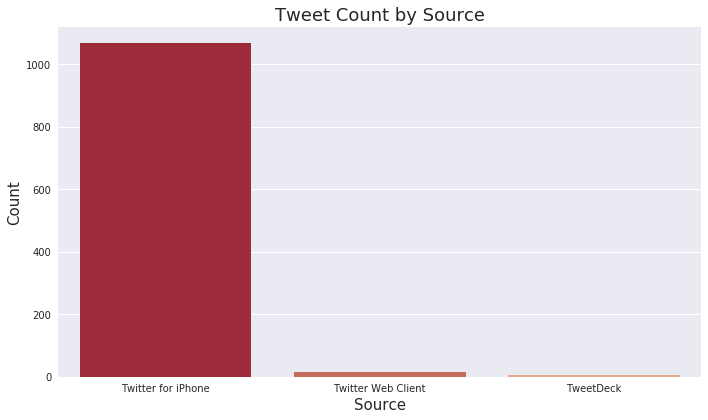

In [73]:
plt.figure(figsize=(10, 6))
sns.set(style = "darkgrid")
sns.countplot(data = df_stats, x = "source", palette = cmap)
plt.title('Tweet Count by Source', fontsize = 18)
plt.xlabel('Source', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.savefig('./assets/images/tweetCountBySource', dpi = 300)
plt.show()
# help(sns.countplot)

Looked at the count of each tweet source.

<a id='two'></a>
### Insight two & visualization

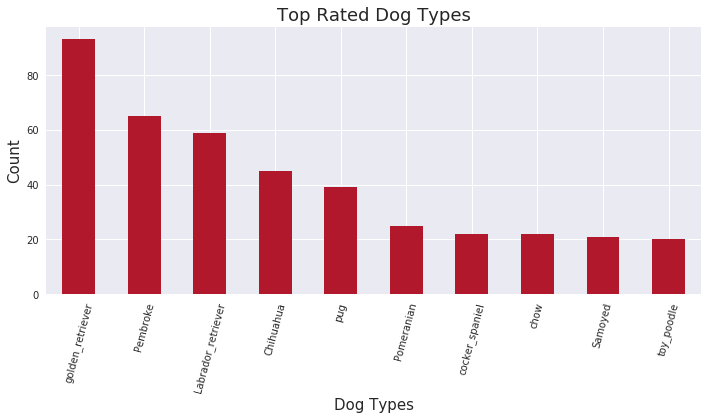

In [74]:
common_dog_types = df_stats.groupby("dogTypeMax").filter(lambda x: len(x) >= 20 and len(x) < 150)

plt.figure(figsize=(10, 6))
common_dog_types["dogTypeMax"].value_counts().plot(kind = 'bar', color = sns.color_palette(cmap))

plt.title('Top Rated Dog Types', fontsize = 18)
plt.xlabel('Dog Types', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 10, rotation=75)
plt.yticks(fontsize = 10)
# plt.ylim(10, 40)
plt.tight_layout()
plt.savefig('./assets/images/topRatedDogTypes', dpi = 300)
plt.show()




This bar garph shows most popular dog types (breeds) in descending order.

<a id='three'></a>
### Insight three & visualization

My hypothesis is popular tweets receive higher amounts of retweets and favorites status.

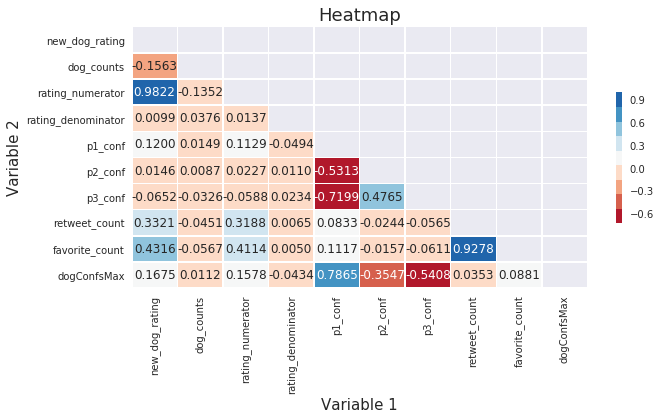

In [75]:
# Compute the correlation matrix
corr = df_stats.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.4f',
            cmap=cmap, cbar=True, ax=ax, mask = mask,
            square=False, linewidths=.5,cbar_kws={"shrink": .5})
ax.set_title('Heatmap', fontsize = 18)
ax.set_xlabel('Variable 1', fontsize = 15)
ax.set_ylabel('Variable 2', fontsize = 15)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal", fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.tight_layout()
plt.savefig('./assets/images/pearsonCorrelation', dpi = 300, bbox_inches='tight', pad_inches=0.0)
plt.show()

I needed help masking the parallel values within this heatmap [<sup>9</sup>](#resources) . Notice the pearson correlation coifficient between retweet count and favorite count (0.9276) is easy to spot when compared to a normal heatmap correlation matrix that duplicates values. This is considered a strong positive correlation.

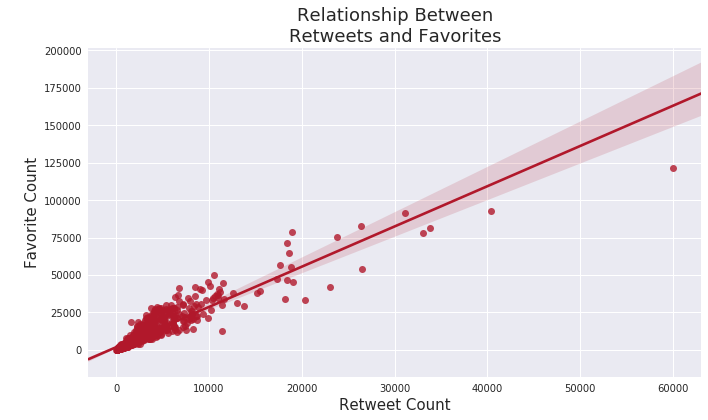

In [76]:
plt.figure(figsize=(10, 6))
sns.regplot(data = df_stats, x = "retweet_count", y = "favorite_count", 
            ci = 95, color = cmap[0])
plt.title('Relationship Between\nRetweets and Favorites', fontsize = 18)
plt.xlabel('Retweet Count', fontsize = 15)
plt.ylabel('\nFavorite Count', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.savefig('./assets/images/relationshipRetweetsAndFavorites', dpi = 300)
plt.show()
# help(sns.regplot)

This graph displays a positive correlation between retweet count and favorite count.

<a id='four'></a>
### Insight four & visualization

In [77]:
df_stats.to_csv('./assets/df_stats.csv', encoding = 'utf-8')
# df_stats[['rating_numerator', 'new_dog_rating']]

In [78]:
# summary of central tendancy and interquartile ranges
df_stats.groupby('developmentalStage')["new_dog_rating"].describe()

,count,mean,std,min,25%,50%,75%,max
developmentalStage,,,,,,,,
doggo,29.0,11.586207,1.570197,8.0,11.00,11.0,13.00,14.0
floofer,4.0,11.500000,1.290994,10.0,10.75,11.5,12.25,13.0
multi-entry,7.0,11.000000,2.708013,5.0,11.50,12.0,12.00,13.0
no-entry,919.0,10.703667,1.836619,2.0,10.00,11.0,12.00,14.0
pupper,116.0,10.780172,1.422320,7.0,10.00,11.0,12.00,14.0
puppo,14.0,11.785714,1.423893,9.0,11.00,12.0,13.00,14.0


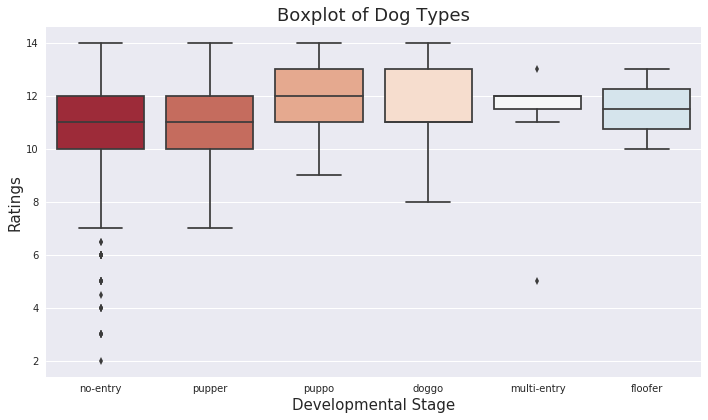

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_stats, x = "developmentalStage", y = "new_dog_rating", palette = cmap)
plt.title('Boxplot of Dog Types', fontsize = 18)
plt.xlabel('Developmental Stage', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.savefig('./assets/images/boxplotDogTypes', dpi = 300)
plt.show()
# help(sns.boxplot)

Box plot displays the range of ratings for each developmental stage. 

<a id='storing'></a>
## Storing

In [80]:
df_cleanData.to_csv('./assets/twitter_archive_master.csv', encoding = 'utf-8')

<a id='resources'></a>
### Resources

1. *Kazil, J., & Jarmul, K. (2016). Data wrangling with Python: Tips and tools to make your life easier.*

* *Dale, K. (2016). Data visualization with Python & Javascript: Scrape, clean, explore & transform your data.*

* *McKinney, W. (2018). Python for data analysis: Data wrangling with Pandas, NumPy, and IPython.*

* *Schutt, R., & ONeil, C. (2014). Doing data science.*

* [Example Project Layout Template](https://github.com/latinacode/Wrangle-and-Analyze-Data/blob/master/wrangle_act.ipynb)

* [Time Delay](https://www.pythoncentral.io/pythons-time-sleep-pause-wait-sleep-stop-your-code/)

* [Joining Dataframes with Pandas](https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/)

* [Lambda](http://jamie-wong.com/2009/12/06/lambda-functions/)

* [Heatmap Pearson Correlation](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)